# Walter 1994 - 2D

In [16]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#add mf6rtm path to the system
sys.path.insert(0,os.path.join("..","..","mf6rtm"))
import flopy
import mf6rtm
import utils

prefix = 'walter1994'
DT_FMT = "%Y-%m-%d %H:%M:%S"

In [17]:
import re
import difflib

#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

# Model Constants

In [18]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 10  # Number of layers
Lx = 100 #m
ncol = 25 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 10.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 10  # Time step ($days$)
perlen = 2000  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#hydraulic properties
prsity = 0.35  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*10
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
l_hd = 12
r_hd = 10
strt = np.ones((nlay, nrow, ncol), dtype=float)*10
strt[:, 0, 0] = l_hd  # Starting head ($m$)

chdspd = [[(i, 0, 0), l_hd] for i in range(nlay)] # Constant head boundary $m$
chdspd.extend([(i, 0, ncol - 1), r_hd] for i in range(nlay))

# chdspd_tail = [[(i, 0, 0), l_hd] for i in range(0,3)]

#transport
dispersivity = 2.5 # Longitudinal dispersivity ($m$)
disp_tr_vert = 0.025 # Transverse vertical dispersivity ($m$)


icelltype = 0  # Cell conversion type
# ibound = np.ones((nlay, nrow, ncol), dtype=int)
# ibound[:, 0, -1] = -1
# ibound[:, 0, 0] = -1



# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

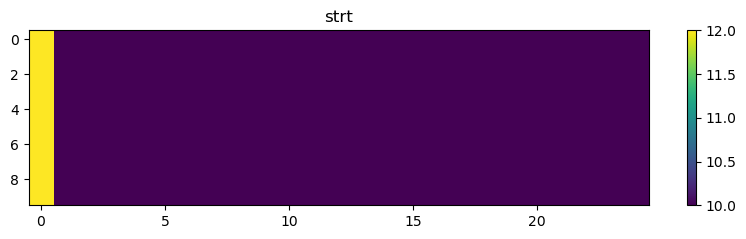

In [19]:
# # make a figure with subplots showing ibound and strt 
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(2, 1, 2)
ax.set_title('strt')
im = ax.imshow(strt[:, 0, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)


## Initialize Chemistry

In [20]:
dataws = os.path.join("..", "data")

files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
solutionsdf

,sol_bck,sol_tail
comp,,
pH,6.960000e+00,3.990000e+00
pe,1.670000e+00,7.690000e+00
C(+4),3.940000e-03,4.920000e-04
S(6),7.480000e-03,5.000000e-02
Fe(+2),5.390000e-05,3.060000e-02
Fe(+3),2.320000e-08,1.990000e-07
Mn(+2),4.730000e-05,9.830000e-06
Ca,6.920000e-03,1.080000e-02
Mg,1.960000e-03,9.690000e-04


In [21]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases


# equlibrium phases is a dictionary with keys as the phase number, values is another dictionary with phase name and an array of saturation indices as element 0 and concentrations as element 1. multiply the concentrations by 2
for key, value in equilibrium_phases.items():
    for k, v in value.items():
        v[-1] = mf6rtm.concentration_volbulk_to_volwater( v[-1], prsity)
equilibrium_phases

{1: {'Calcite': [0.0, 0.055714285714285716],
  'Siderite': [0.0, 0.012057142857142857],
  'Gibbsite': [0.0, 0.007171428571428572],
  'Fe(OH)3(a)': [0.0, 0.005314285714285715],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 1.1628571428571428]}}

In [22]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=int)
#slice nlay = 0 in sol_ic
# sol_ic[0:3,:,0] = 2


#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
eqp_ic = np.ones((nlay, nrow, ncol), dtype=int)*1
eqp_ic[3:,:,0]= -1 #boundary condation in layer 0 of no eq phases
equilibrium_phases.set_ic(eqp_ic)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}_mf6rtm'))

#set database
database = os.path.join('..', 'database', f'pht3d_datab_walter1994.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

#get phreeqc input
phinp = model.generate_phreeqc_script(postfix =  postfix)

In [23]:
eqp_ic

array([[[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1]],

       [[-1,  1,  1,  1,  1,  1,

In [24]:
equilibrium_phases.data

{0: {'Calcite': [0.0, 0.055714285714285716],
  'Siderite': [0.0, 0.012057142857142857],
  'Gibbsite': [0.0, 0.007171428571428572],
  'Fe(OH)3(a)': [0.0, 0.005314285714285715],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 1.1628571428571428]}}

In [25]:
model.set_charge_offset(0.0)

In [26]:
wellchem = mf6rtm.ChemStress('chdtail')
sol_spd = [2]
sol_spd
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)
model.chdtail.data


Initializing ChemStress
ChemStress chdtail initialized


{0: [110692.76183188436,
  55550.814848921545,
  -0.07000263722585498,
  4.2872849946781235,
  0.4905451627039262,
  10.768064547190578,
  0.11864811862182262,
  30.509714776780367,
  0.790655109807607,
  0.9661346802062666,
  0.009800932823970992,
  1.3858897889439774,
  49.852150766561444,
  2.0738494683478224]}

In [27]:
#initialize model
model.initialize()

Phreeqc initialized


In [28]:
for i in range(len(chdspd)):
    if i<3:
        chdspd[i].extend(model.chdtail.data[0])
    else:
        chdspd[i].extend(np.zeros_like(model.chdtail.data[0]))
print(chdspd)

[[(0, 0, 0), 12, 110692.76183188436, 55550.814848921545, -0.07000263722585498, 4.2872849946781235, 0.4905451627039262, 10.768064547190578, 0.11864811862182262, 30.509714776780367, 0.790655109807607, 0.9661346802062666, 0.009800932823970992, 1.3858897889439774, 49.852150766561444, 2.0738494683478224], [(1, 0, 0), 12, 110692.76183188436, 55550.814848921545, -0.07000263722585498, 4.2872849946781235, 0.4905451627039262, 10.768064547190578, 0.11864811862182262, 30.509714776780367, 0.790655109807607, 0.9661346802062666, 0.009800932823970992, 1.3858897889439774, 49.852150766561444, 2.0738494683478224], [(2, 0, 0), 12, 110692.76183188436, 55550.814848921545, -0.07000263722585498, 4.2872849946781235, 0.4905451627039262, 10.768064547190578, 0.11864811862182262, 30.509714776780367, 0.790655109807607, 0.9661346802062666, 0.009800932823970992, 1.3858897889439774, 49.852150766561444, 2.0738494683478224], [(3, 0, 0), 12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [(4, 0, 0

In [29]:
# eqp_ic[0:3,:,0]= -1
# model.phreeqc_rm.InitialPhreeqc2Concentrations(np.reshape(sol_ic, nlay*nrow*ncol))
# wellchem = mf6rtm.ChemStress('wel')

# sol_spd = [2]

# wellchem.set_spd(sol_spd)
# model.set_chem_stress(wellchem)
# model.wel.data
# model.wel.auxiliary
# model.components
model.sconc['Charge']
model.components


['H',
 'O',
 'Charge',
 'Al',
 'C',
 'Ca',
 'Cl',
 'Fe',
 'K',
 'Mg',
 'Mn',
 'Na',
 'S',
 'Si']

# Build model

In [30]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # for i in range(len(chdspd_tail)):
    #     chdspd_tail[i].extend(model.chdtail.data[0])
    # # Instantiating MODFLOW 6 constant head package
    # chd_tail = flopy.mf6.ModflowGwfchd(
    #     gwf,
    #     maxbound=len(chdspd_tail),
    #     stress_period_data=chdspd_tail,
    #     auxiliary=mup3d.components,
    #     save_flows=True,
    #     pname="CHDTAIL",
    #     filename=f"{gwfname}.chdtail",
    # )
    # chd_tail.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        # cncspd = {0: [[(0, 0, col), conc] for col, conc in zip(range(ncol), model.sconc[c][0,0,:])]}
        cncspd = {0: [[(ly, 0, 0), model.sconc[c][ly,0,0]] for ly in range(3,nlay)]}

        # print(cncspd)
        cnc = flopy.mf6.ModflowGwtcnc(gwt,
                                        # maxbound=len(cncspd),
                                        stress_period_data=cncspd,
                                        save_flows=True,
                                        print_flows = True,
                                        pname="CNC",
                                        filename=f"{gwtname}.cnc",
                                        )
        cnc.set_all_data_external()
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['chd', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))*disp_tr_vert  # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [31]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Al
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--

In [32]:
model.run_mup3d(sim, reaction=True)



-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Al, C, Ca, Cl, Fe, K, Mg, Mn, Na, S, Si
Starting transport solution at 2024-07-12 15:45:51

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 2 iters --- took 0.00041158 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took 0.00049492 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 17 iters --- took  0.0006034 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 21 iters --- took 0.00068673 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 1 --- converged with 27 iters --- took 0.00077857 mins

Solution 5 finalized

Solvin

In [33]:
def get_lst_budget(ws='.', comp = '', start_datetime=None):
    budgetkey  = 'MASS BUDGET FOR ENTIRE MODEL'
    lst = flopy.utils.Mf6ListBudget(os.path.join(ws,f"{comp}.lst"), budgetkey = budgetkey)
    inc,cum = lst.get_dataframes(start_datetime=start_datetime)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "time"
    cum.index.name = "time"
    return inc, cum

In [34]:
inc, cum = get_lst_budget(ws = os.path.join(model.wd), comp = 'K')
inc

,storage-aqueous-in,chd-in,cnc-in,total-in,storage-aqueous-out,chd-out,cnc-out,total-out,in-out,percent-discrepancy
time,,,,,,,,,,
10.0,8.818900e-09,0.049416,0.009595,0.059011,0.034565,0.013813,0.010633,0.059011,2.547600e-10,0.0
20.0,5.578300e-09,0.049416,0.009453,0.058869,0.028389,0.013813,0.016667,0.058869,2.106300e-10,0.0
30.0,2.895000e-09,0.049416,0.009263,0.058679,0.024409,0.013813,0.020457,0.058679,4.501600e-10,0.0
40.0,1.998900e-09,0.049416,0.009049,0.058464,0.021681,0.013813,0.022970,0.058464,2.513300e-10,0.0
50.0,1.617200e-09,0.049416,0.008824,0.058240,0.019740,0.013813,0.024688,0.058240,5.043700e-11,0.0
...,...,...,...,...,...,...,...,...,...,...
1960.0,0.000000e+00,0.049416,0.006712,0.056128,0.002266,0.024573,0.029290,0.056128,-6.864400e-09,-0.0
1970.0,0.000000e+00,0.049416,0.006712,0.056128,0.002194,0.024645,0.029290,0.056128,-6.781500e-09,-0.0
1980.0,0.000000e+00,0.049416,0.006712,0.056128,0.002123,0.024715,0.029290,0.056128,-6.693600e-09,-0.0


# Plots

In [50]:
wd = os.path.join(f'{prefix}_pht3d')
# dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

#offset index of simapi by tstep
simapi.index = simapi.index + tstep
#simapi drop S-2 column
simapi.drop(columns = ['S-2'], inplace = True)
simapi


# wd = os.path.join(f'{prefix}_pht3d')
# wd = os.path.join(f'{prefix}_pht3d', 'nortm')

# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]

#read pht3dpy file
ucndic = {}
pht3dpy = os.path.join(wd, pht3dpy[0])
with open(pht3dpy, 'r') as f:
    # print(f.read())
    for l in f:
        n =re.findall(r'\d+', l.split()[-1])[-1]
        ucndic[l.split()[0].replace('_', "")] = f"PHT3D{n}.UCN"
        
for k,v in ucndic.items():
    ucn = flopy.utils.HeadFile(os.path.join(wd, v),text=f"concentration")
    results = ucn.get_alldata()
    ucndic[k] = results
timespht3d = ucn.get_times()
    
for var in simapi.columns:
    closest_match = find_closest_match(var, ucndic)
    if closest_match:
        ucndic[var] = ucndic.pop(closest_match)
        # print(f"Closest match to {var}: {closest_match}")
simapi.iloc[1:,:-7]

ucndic['K'].shape

(100, 1, 10, 25)

In [51]:
wd = os.path.join(f'{prefix}_mf6rtm')
# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

ucndic_mf6 = {}
for k in ucn_files:
    ucn = flopy.utils.HeadFile(os.path.join(wd, k),text=f"concentration")
    results = ucn.get_alldata()
    ucndic_mf6[f'{k.split(".")[0]}'] = results
times = ucn.get_times()

In [52]:
ucndic.keys(), ucndic_mf6.keys()



(dict_keys(['pH', 'pe', 'Ca', 'Cl', 'C4', 'Mg', 'S6', 'Fe2', 'Fe3', 'Mn2', 'Na', 'K', 'Al', 'Si', 'Calcite', 'Siderite', 'Gibbsite', 'Gypsum', 'Fe(OH)3(a)', 'SiO2(a)']),
 dict_keys(['Al', 'C', 'Ca', 'Charge', 'Cl', 'Fe', 'H', 'K', 'Mg', 'Mn', 'Na', 'O', 'S', 'Si']))

In [53]:
ucndic_mf6['K'].shape, ucndic['K'].shape
ucndic.keys(), ucndic_mf6.keys()

(dict_keys(['pH', 'pe', 'Ca', 'Cl', 'C4', 'Mg', 'S6', 'Fe2', 'Fe3', 'Mn2', 'Na', 'K', 'Al', 'Si', 'Calcite', 'Siderite', 'Gibbsite', 'Gypsum', 'Fe(OH)3(a)', 'SiO2(a)']),
 dict_keys(['Al', 'C', 'Ca', 'Charge', 'Cl', 'Fe', 'H', 'K', 'Mg', 'Mn', 'Na', 'O', 'S', 'Si']))

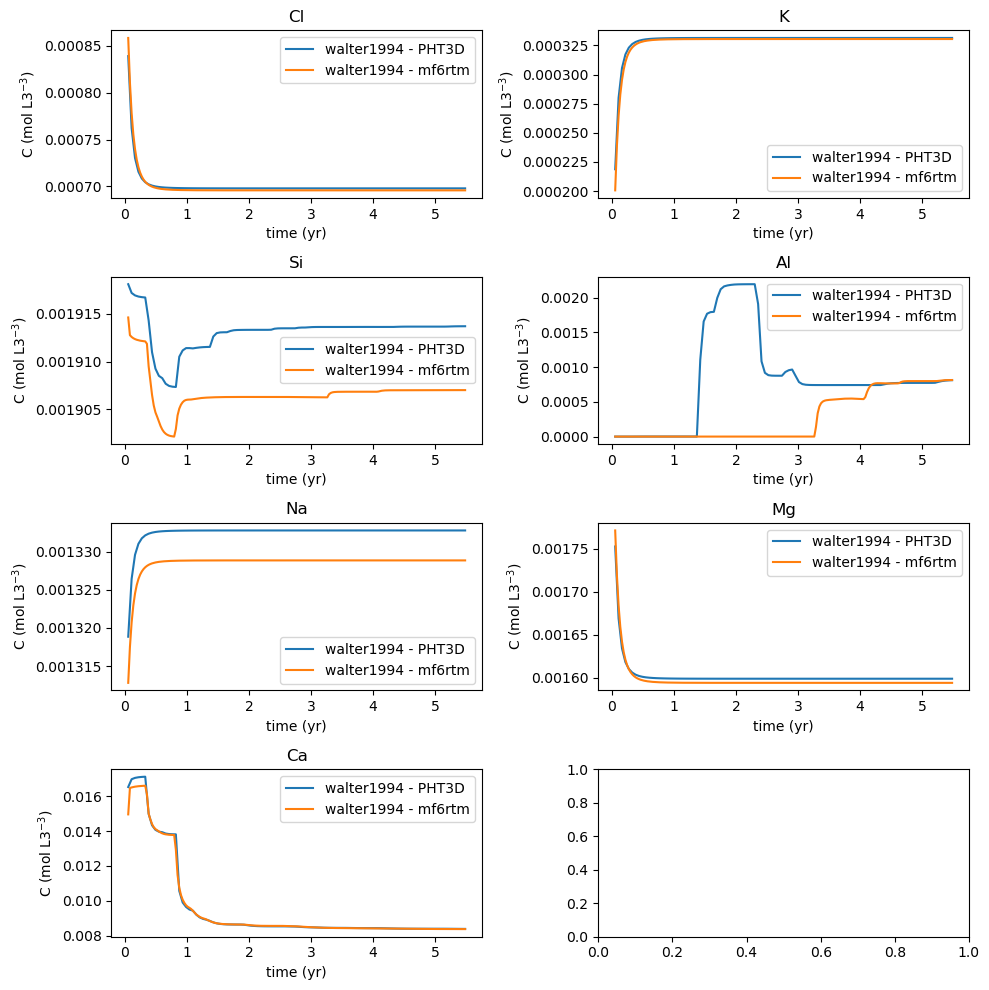

In [54]:
#get common keys from ucndic and ucndic_mf6
common_keys = set(ucndic.keys()).intersection(ucndic_mf6.keys())
common_keys

pncol=2
variables = common_keys

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 10))
for var, ax in zip(common_keys, axs.flatten()):
    ax.plot([x/365 for x in timespht3d], ucndic[var][:,0,0,0], label = f'{prefix} - PHT3D')
    ax.plot([x/365 for x in times[1:]], ucndic_mf6[var][1:,0,0,0]/1000, label = f'{prefix} - mf6rtm')

    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.8, xmax*1.2)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L3$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

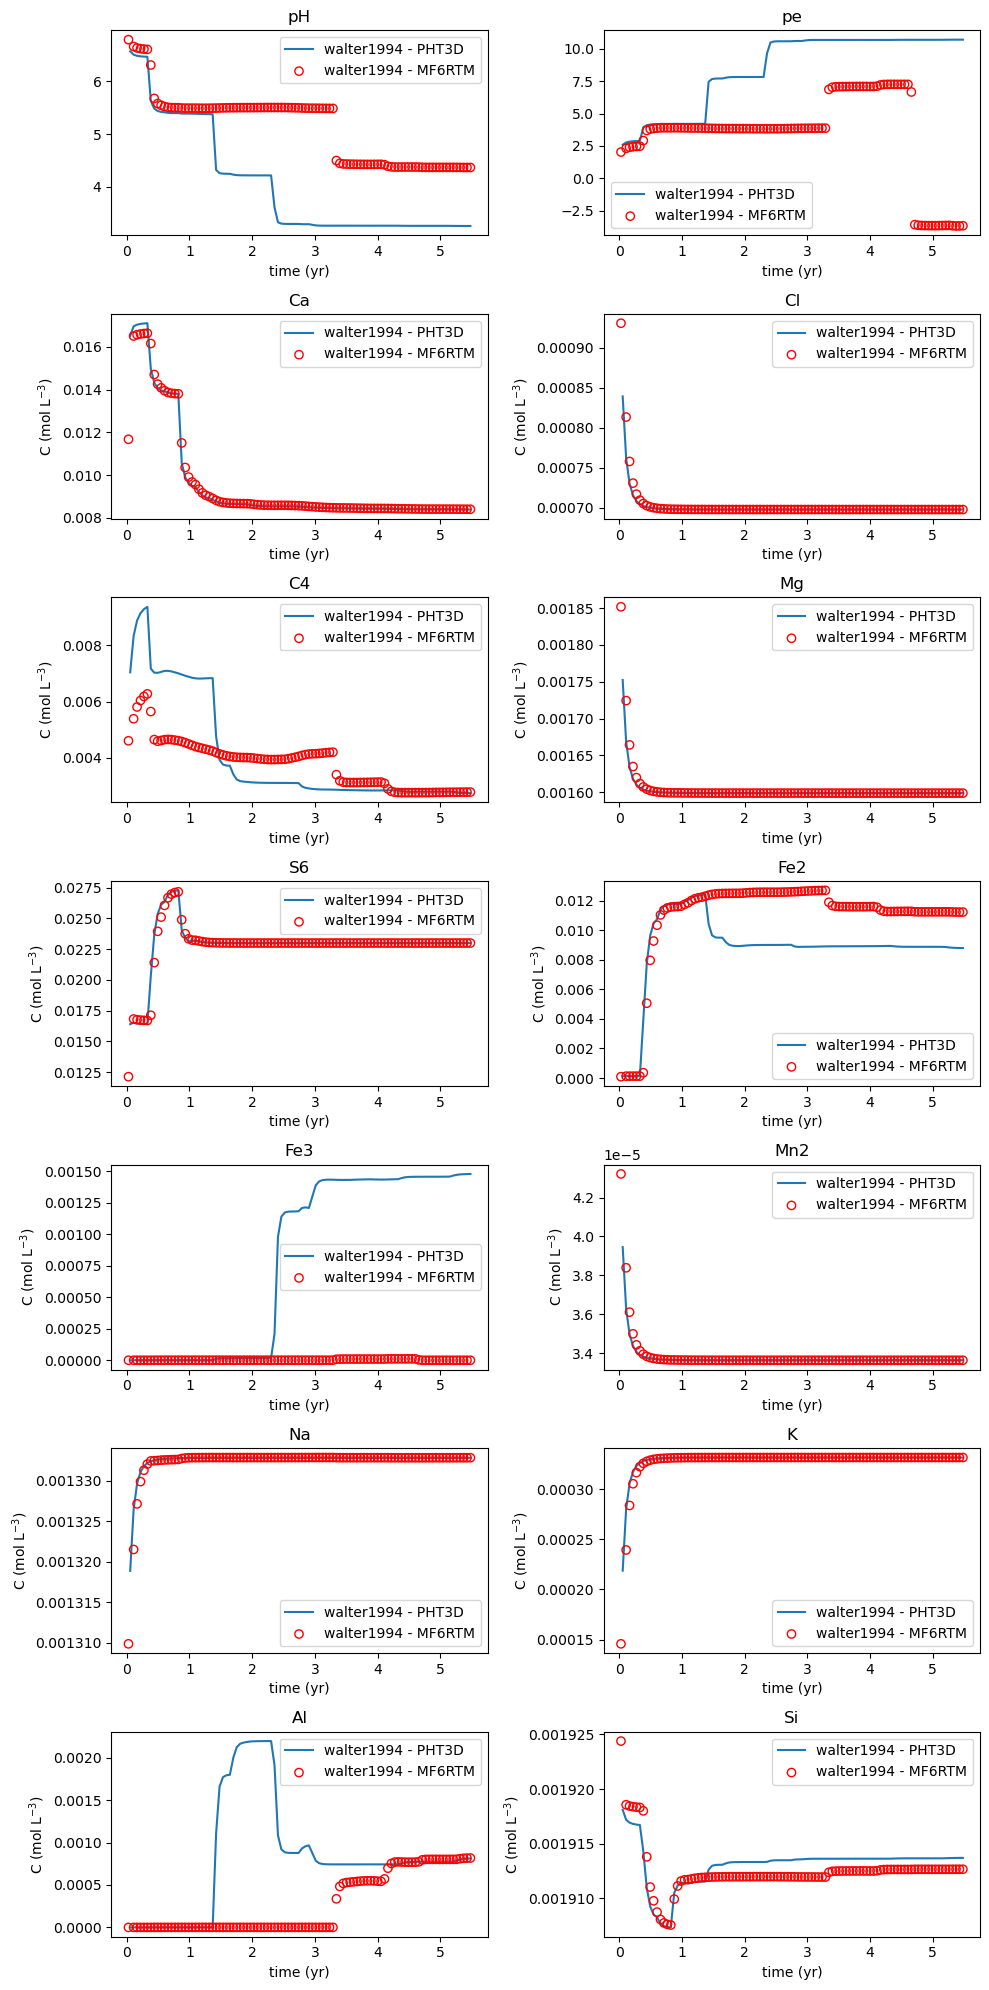

In [55]:
pncol=2
variables = simapi.iloc[:,1:-7 ].columns #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 20))
for var, ax in zip(simapi.iloc[:,1:-7 ].columns, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == 0.].copy()
    t = df.index/365

    ax.plot([x/365 for x in timespht3d], ucndic[var][:,0,0,0], label = f'{prefix} - PHT3D')
    ax.scatter(t[::2], df.loc[:, var][::2], label = f'{prefix} - MF6RTM', 
               facecolors='none', edgecolors='r', zorder = 10)
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.9, xmax*1.1)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

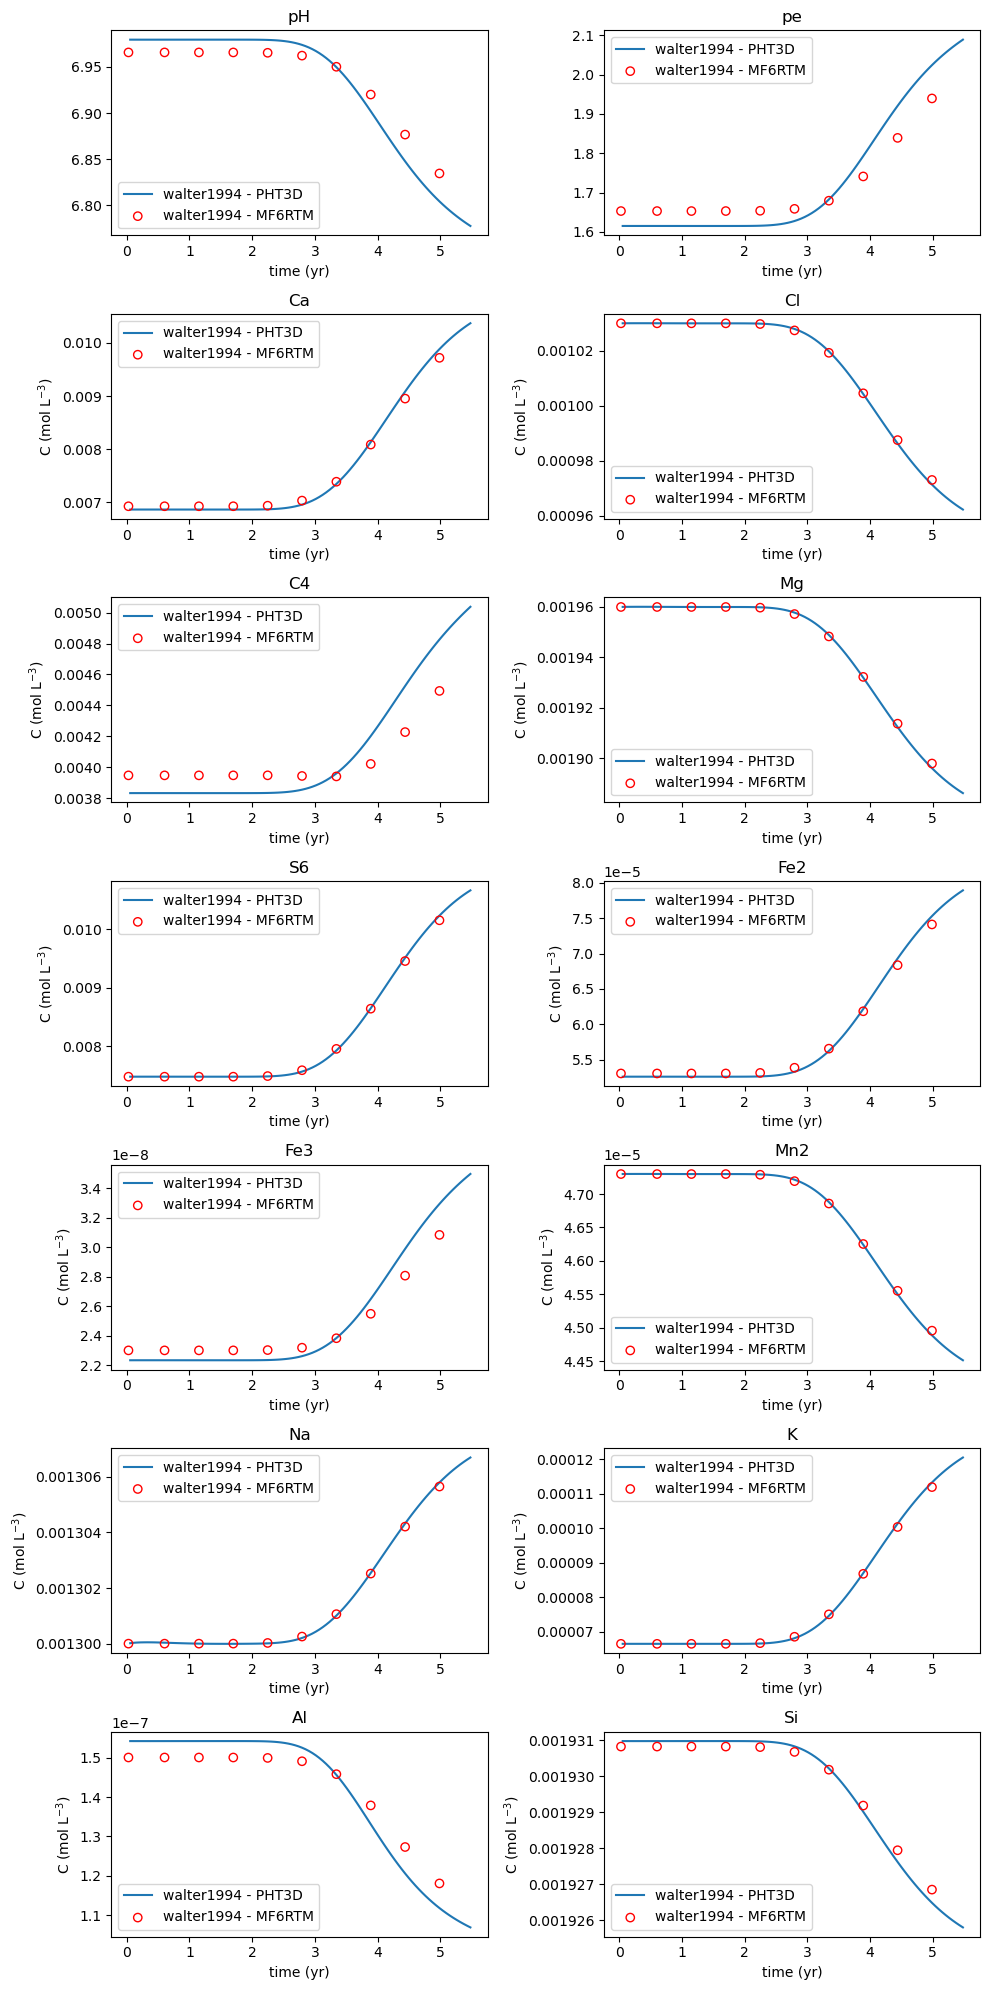

In [56]:
pncol=2
variables = simapi.iloc[:,1:-7 ].columns #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 20))
for var, ax in zip(simapi.iloc[:,1:-7 ].columns, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == 249.].copy()
    t = df.index/365

    ax.plot([x/365 for x in timespht3d], ucndic[var][:,0,-1,-1], label = f'{prefix} - PHT3D')
    ax.scatter(t[::20], df.loc[:, var][::20], label = f'{prefix} - MF6RTM', 
               facecolors='none', edgecolors='r', zorder = 10)
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.9, xmax*1.1)

    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

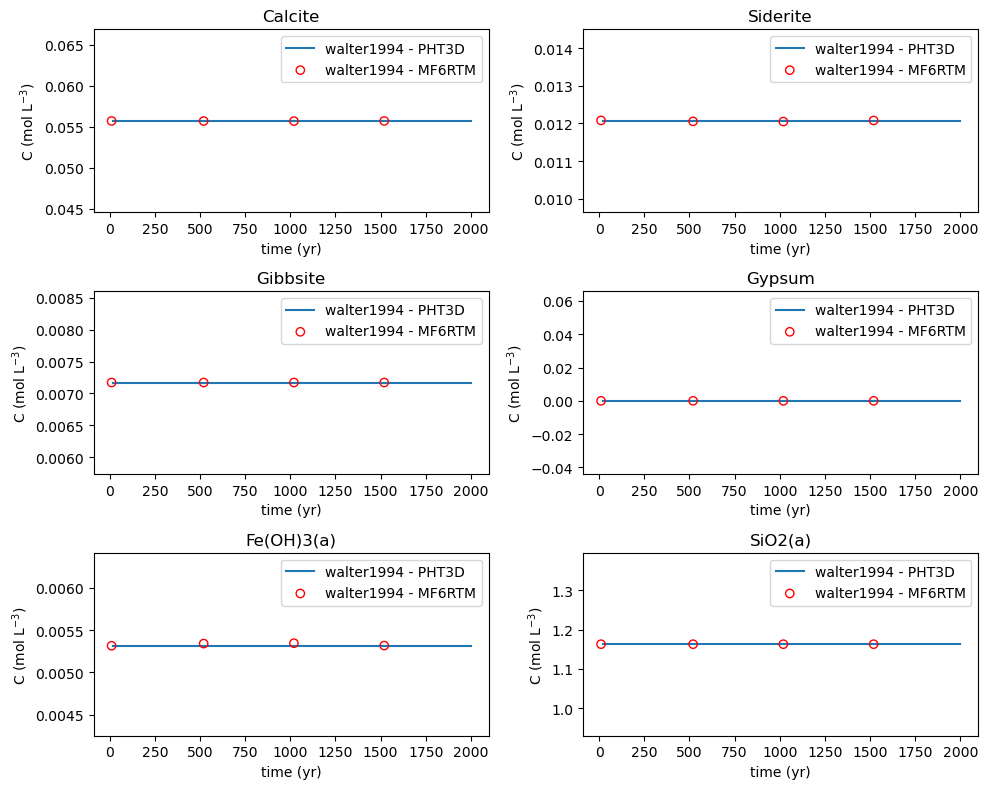

In [46]:
variables = simapi.iloc[:, -7: -1].columns #dissolved only
pncol=2
pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (10, 8))
for var, ax in zip(variables, axs.flatten()):
    # print(ucndic[var][:,-1,0,-1])
    # ax.plot(simdf.x.unique(), simdf.loc[perlen, var], label = 'Engesgaard1992 - PHT3D')
    df = simapi[simapi['cell'] == 7.].copy()
    t = df.index
    ax.plot(timespht3d, ucndic[var][:,0,-1,0], label = f'{prefix} - PHT3D')
    # ax.plot(simapi.x.unique(), simapi.loc[simapi.index.unique()[-1], var], label = 'Engesgaard1992 - MF6RTM')
    # ax.plot(df.index, df.loc[:, var], label = f'{prefix} - PHT3D')
#     df = simapi[simapi['cell'] == 249.].copy()
    ax.scatter(t[::50], df.loc[:, var][::50], label = f'{prefix} - MF6RTM', edgecolors='r', facecolors='none', zorder = 10)
    ax.set_xlabel('time (yr)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L$^{-3}$)')
    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    ax.set_ylim(xmin*.8, xmax*1.2) 
    
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()

In [42]:
ucndic[var].shape

(100, 1, 10, 25)

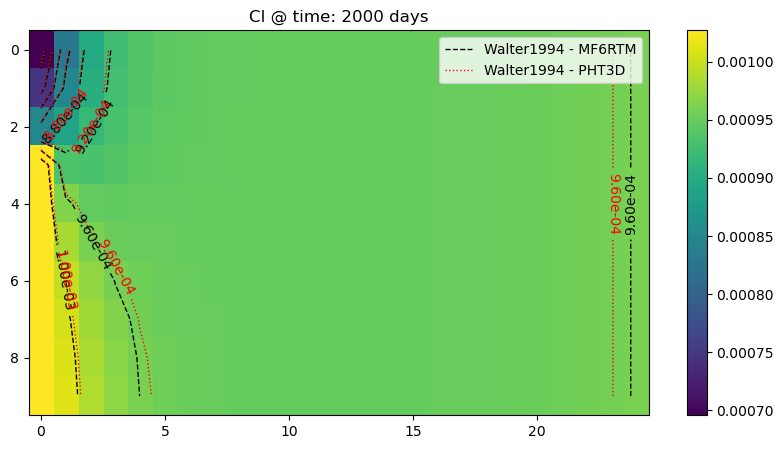

In [47]:
t = 2000
v = 'Cl'
# simapi.loc[t, v].values
# vmin = np.min(simapi.loc[t, v].values)
# vmax =  np.max(simapi.loc[t, v].values)
# levels = np.linspace(vmin, vmax, 4)
fmt = '%1.2e'
# arr  = np.reshape(simapi.loc[t, v].values, (nlay, nrow, ncol))
arr = ucndic_mf6[v]
# arr = arr[1:]
# ucndic[var][:,-1,0,-1]
fig, axs = plt.subplots(1,1,figsize=(10, 5))
ax = axs
ax.set_title(f'{v} @ time: {t} days')
im1 = ax.imshow(arr[-1,:,0,:]/1000, aspect = 'auto')
cbar = plt.colorbar(im1, ax=ax)

# add contour labels
cntr1 = ax.contour(arr[-1,:,0,:]/1000, levels = 10, colors='k', 
                   linestyles = 'dashed', linewidths = 1)  
#add contour labels
ax.clabel(cntr1, inline=True, fontsize=10, fmt=fmt)
# im2 = ax.imshow(ucndic[v][-1,0,:,:], aspect = 'auto')
# cbar = plt.colorbar(im, ax=ax)

cntr2 = ax.contour(ucndic[v][-1,0,:,:], levels = 10, colors='r',
                   linestyles = 'dotted',  linewidths = 1) 
ax.clabel(cntr2, inline=True, fontsize=10, fmt=fmt)
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
ax.legend([h1[0], h2[0]], [f'{prefix.capitalize()} - MF6RTM', f'{prefix.capitalize()} - PHT3D'])

In [ ]:
arr[-1,:,0,:].shape, ucndic['K'][-1,0,:,:].shape

In [ ]:
fmt = '%1.2e'

fig, axs = plt.subplots(1,1,figsize=(10, 5))
ax = axs
im2 = ax.imshow(ucndic['K'][-1,0,:,:], aspect = 'auto')
cbar = plt.colorbar(im2, ax=ax)
cntr2 = plt.contour(ucndic[v][-1,0,:,:], levels = 10, colors='r',
                   linestyles = 'dotted',  linewidths = 1) 
plt.clabel(cntr2, inline=True, fontsize=10, fmt=fmt)


In [ ]:
simapi.loc[t, v].nunique()

In [ ]:
simapi.loc[t, v].values[nlay:]

In [ ]:
#plot heads of gwf model from mf6 sim with flopy
hds = flopy.utils.HeadFile(os.path.join(model.wd, 'gwf.hds'))
headmf6 = hds.get_alldata()

# plot with flopy
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Head')
im = ax.imshow(headmf6[-1, :, 0, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)
#add contours   
levels = np.linspace(headmf6[-1, :, 0, :].min(), headmf6[-1, :, 0, :].max(), 10)
cntr = ax.contour(headmf6[-1, :, 0, :], levels = levels, colors='k', linestyles = 'dashed', linewidths = 1)
ax.clabel(cntr, inline=True, fontsize=10, fmt='%1.1f')
plt.show()


In [ ]:
#plot the heads from pht3d model
wd = os.path.join(f'{prefix}_pht3d')

hds = flopy.utils.HeadFile(os.path.join(wd, f'{prefix}.head'))
head = hds.get_alldata()
head.shape

#plot heads
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Head')
im = ax.imshow(head[-1, 0, :, :], aspect = 'auto')
cbar = plt.colorbar(im, ax=ax)
#add contours
levels = np.linspace(head[0, 0, :, :].min(), head[0, 0, :, :].max(), 10)
cntr = ax.contour(head[0, 0, :, :], levels = levels, colors='k', linestyles = 'dashed', linewidths = 0.5)

levels = np.linspace(headmf6[-1, :, 0, :].min(), headmf6[-1, :, 0, :].max(), 10)
cntr = ax.contour(headmf6[-1, :, 0, :], levels = levels, colors='w', linestyles = 'dotted', linewidths = 0.5)
ax.clabel(cntr, inline=True, fontsize=10, fmt='%1.1f')
